# DPG for Cartpole


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/aras/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [6]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.921946114031699 -2.9887773478448816
actions: 1 0
rewards: 1.0 1.0


In [7]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [8]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [9]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [10]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [11]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [12]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [13]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG: r+(gamma*nextQ)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True) # Qs
    rates = tf.reshape(rates, shape=[-1, 1])
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=rates)) # 0-1
    dlossA /= 2
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    dlossQ /= 2
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [14]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [15]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [16]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [17]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [18]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [19]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [50]:
goal = 500
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done), -1])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/goal
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        num_step = 0 # reset

In [51]:
idx = np.random.choice(np.arange(memory_size// batch_size))
batch = np.array(memory.buffer)[idx*batch_size:(idx+1)*batch_size]
rates = np.array([each[5] for each in batch])
batch = batch[rates >= (np.max(rates)*0.9)]
states = np.array([each[0] for each in batch])
actions = np.array([each[1] for each in batch])
next_states = np.array([each[2] for each in batch])
rewards = np.array([each[3] for each in batch])
dones = np.array([each[4] for each in batch])
rates = np.array([each[5] for each in batch])

In [54]:
batch.shape, \
states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape

((44, 6), (44, 4), (44,), (44, 4), (44,), (44,), (44,))

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [55]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111):
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        total_reward = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), -1])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the last played episode
            if done is True:
                rate = total_reward/ goal # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                        memory.buffer[-1-idx][5] = rate # rate each SA pair
            
            # Training using a max rated batch
            idx = np.random.choice(np.arange(memory_size// batch_size))
            batch = np.array(memory.buffer)[idx*batch_size:(idx+1)*batch_size]
            rates = np.array([each[5] for each in batch])
            batch = batch[rates >= (np.max(rates)*0.9)]
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rates = np.array([each[5] for each in batch])            
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dlossA, dlossQ, _, _, _ = sess.run([model.g_loss, model.d_lossA, model.d_lossQ, 
                                                       model.g_opt, model.d_optA, model.d_optQ],
                                                      feed_dict = {model.states: states, 
                                                                   model.actions: actions,
                                                                   model.targetQs: targetQs, 
                                                                   model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:22.0000 R:22.0000 rate:0.0440 gloss:0.7338 dlossA:0.7371 dlossQ:0.9349 exploreP:0.9978
Episode:1 meanR:17.0000 R:12.0000 rate:0.0240 gloss:0.7302 dlossA:0.7367 dlossQ:0.9338 exploreP:0.9966
Episode:2 meanR:15.3333 R:12.0000 rate:0.0240 gloss:0.7155 dlossA:0.7258 dlossQ:0.9416 exploreP:0.9955
Episode:3 meanR:18.2500 R:27.0000 rate:0.0540 gloss:0.7244 dlossA:0.7297 dlossQ:0.9362 exploreP:0.9928
Episode:4 meanR:17.8000 R:16.0000 rate:0.0320 gloss:0.7269 dlossA:0.7324 dlossQ:0.9449 exploreP:0.9912
Episode:5 meanR:17.6667 R:17.0000 rate:0.0340 gloss:0.7361 dlossA:0.7378 dlossQ:0.9415 exploreP:0.9896
Episode:6 meanR:17.5714 R:17.0000 rate:0.0340 gloss:0.7374 dlossA:0.7398 dlossQ:0.9395 exploreP:0.9879
Episode:7 meanR:19.2500 R:31.0000 rate:0.0620 gloss:0.7441 dlossA:0.7372 dlossQ:0.9442 exploreP:0.9849
Episode:8 meanR:19.2222 R:19.0000 rate:0.0380 gloss:0.7223 dlossA:0.7327 dlossQ:0.9352 exploreP:0.9830
Episode:9 meanR:19.2000 R:19.0000 rate:0.0380 gloss:0.7236 dlossA:0.7283 

Episode:79 meanR:25.7125 R:64.0000 rate:0.1280 gloss:0.7327 dlossA:0.7435 dlossQ:0.9524 exploreP:0.8159
Episode:80 meanR:26.1852 R:64.0000 rate:0.1280 gloss:0.7247 dlossA:0.7383 dlossQ:0.9574 exploreP:0.8108
Episode:81 meanR:26.3171 R:37.0000 rate:0.0740 gloss:0.7548 dlossA:0.7455 dlossQ:0.9566 exploreP:0.8078
Episode:82 meanR:26.7229 R:60.0000 rate:0.1200 gloss:0.7343 dlossA:0.7418 dlossQ:0.9555 exploreP:0.8031
Episode:83 meanR:26.7857 R:32.0000 rate:0.0640 gloss:0.7232 dlossA:0.7363 dlossQ:0.9603 exploreP:0.8005
Episode:84 meanR:26.9176 R:38.0000 rate:0.0760 gloss:0.7382 dlossA:0.7425 dlossQ:0.9596 exploreP:0.7975
Episode:85 meanR:26.9767 R:32.0000 rate:0.0640 gloss:0.7199 dlossA:0.7334 dlossQ:0.9598 exploreP:0.7950
Episode:86 meanR:26.9195 R:22.0000 rate:0.0440 gloss:0.7410 dlossA:0.7434 dlossQ:0.9609 exploreP:0.7933
Episode:87 meanR:26.8068 R:17.0000 rate:0.0340 gloss:0.7298 dlossA:0.7377 dlossQ:0.9635 exploreP:0.7920
Episode:88 meanR:26.6966 R:17.0000 rate:0.0340 gloss:0.7350 dlos

Episode:158 meanR:46.9800 R:91.0000 rate:0.1820 gloss:0.7439 dlossA:0.7485 dlossQ:0.9592 exploreP:0.5490
Episode:159 meanR:47.1200 R:26.0000 rate:0.0520 gloss:0.7440 dlossA:0.7469 dlossQ:0.9637 exploreP:0.5476
Episode:160 meanR:47.5100 R:63.0000 rate:0.1260 gloss:0.7432 dlossA:0.7466 dlossQ:0.9605 exploreP:0.5443
Episode:161 meanR:48.0300 R:101.0000 rate:0.2020 gloss:0.7367 dlossA:0.7464 dlossQ:0.9605 exploreP:0.5389
Episode:162 meanR:48.3700 R:47.0000 rate:0.0940 gloss:0.7379 dlossA:0.7435 dlossQ:0.9676 exploreP:0.5364
Episode:163 meanR:49.2800 R:123.0000 rate:0.2460 gloss:0.7307 dlossA:0.7425 dlossQ:0.9654 exploreP:0.5300
Episode:164 meanR:49.4500 R:55.0000 rate:0.1100 gloss:0.7208 dlossA:0.7363 dlossQ:0.9669 exploreP:0.5271
Episode:165 meanR:50.9100 R:163.0000 rate:0.3260 gloss:0.7372 dlossA:0.7465 dlossQ:0.9609 exploreP:0.5188
Episode:166 meanR:51.5900 R:107.0000 rate:0.2140 gloss:0.7365 dlossA:0.7451 dlossQ:0.9597 exploreP:0.5134
Episode:167 meanR:54.8600 R:368.0000 rate:0.7360 gl

Episode:236 meanR:248.7400 R:500.0000 rate:1.0000 gloss:2.0100 dlossA:1.6048 dlossQ:0.9102 exploreP:0.0618
Episode:237 meanR:253.4000 R:500.0000 rate:1.0000 gloss:2.0762 dlossA:1.6908 dlossQ:0.9109 exploreP:0.0593
Episode:238 meanR:257.7300 R:457.0000 rate:0.9140 gloss:2.1310 dlossA:1.6895 dlossQ:0.9142 exploreP:0.0571
Episode:239 meanR:262.4400 R:500.0000 rate:1.0000 gloss:2.2000 dlossA:1.6999 dlossQ:0.9165 exploreP:0.0548
Episode:240 meanR:265.1500 R:364.0000 rate:0.7280 gloss:2.2641 dlossA:1.8574 dlossQ:0.9222 exploreP:0.0532
Episode:241 meanR:267.0800 R:313.0000 rate:0.6260 gloss:2.2993 dlossA:1.9666 dlossQ:0.9229 exploreP:0.0519
Episode:242 meanR:271.5100 R:500.0000 rate:1.0000 gloss:2.3460 dlossA:1.8890 dlossQ:0.9265 exploreP:0.0498
Episode:243 meanR:276.3400 R:500.0000 rate:1.0000 gloss:2.4096 dlossA:1.9686 dlossQ:0.9339 exploreP:0.0479
Episode:244 meanR:280.5400 R:500.0000 rate:1.0000 gloss:2.5023 dlossA:2.0532 dlossQ:0.9458 exploreP:0.0460
Episode:245 meanR:284.8600 R:500.0000

Episode:313 meanR:467.6800 R:500.0000 rate:1.0000 gloss:15.7621 dlossA:9.6414 dlossQ:9.2494 exploreP:0.0113
Episode:314 meanR:467.6800 R:500.0000 rate:1.0000 gloss:15.6182 dlossA:9.4960 dlossQ:8.5264 exploreP:0.0113
Episode:315 meanR:467.6800 R:500.0000 rate:1.0000 gloss:15.9399 dlossA:9.5406 dlossQ:10.0224 exploreP:0.0112
Episode:316 meanR:467.6800 R:500.0000 rate:1.0000 gloss:15.8483 dlossA:10.2437 dlossQ:11.1261 exploreP:0.0112
Episode:317 meanR:467.6800 R:500.0000 rate:1.0000 gloss:16.0191 dlossA:9.5483 dlossQ:11.0304 exploreP:0.0111
Episode:318 meanR:467.6800 R:500.0000 rate:1.0000 gloss:16.1020 dlossA:10.0266 dlossQ:10.7687 exploreP:0.0110
Episode:319 meanR:467.6800 R:500.0000 rate:1.0000 gloss:16.2214 dlossA:9.3534 dlossQ:11.0848 exploreP:0.0110
Episode:320 meanR:468.1900 R:500.0000 rate:1.0000 gloss:16.0830 dlossA:9.7737 dlossQ:10.9133 exploreP:0.0109
Episode:321 meanR:470.8000 R:500.0000 rate:1.0000 gloss:16.4466 dlossA:9.1870 dlossQ:11.4423 exploreP:0.0109
Episode:322 meanR:4

Episode:389 meanR:498.0700 R:500.0000 rate:1.0000 gloss:26.3863 dlossA:2.4991 dlossQ:27.2700 exploreP:0.0100
Episode:390 meanR:498.0700 R:500.0000 rate:1.0000 gloss:26.7721 dlossA:3.1126 dlossQ:28.2688 exploreP:0.0100
Episode:391 meanR:498.0700 R:500.0000 rate:1.0000 gloss:25.6204 dlossA:1.6298 dlossQ:30.3778 exploreP:0.0100
Episode:392 meanR:498.0700 R:500.0000 rate:1.0000 gloss:24.2883 dlossA:1.7602 dlossQ:23.8388 exploreP:0.0100
Episode:393 meanR:498.0700 R:500.0000 rate:1.0000 gloss:24.7109 dlossA:0.9757 dlossQ:25.1272 exploreP:0.0100
Episode:394 meanR:498.0700 R:500.0000 rate:1.0000 gloss:24.6207 dlossA:1.0673 dlossQ:24.4823 exploreP:0.0100
Episode:395 meanR:498.0700 R:500.0000 rate:1.0000 gloss:24.9291 dlossA:0.8766 dlossQ:26.3307 exploreP:0.0100
Episode:396 meanR:498.0700 R:500.0000 rate:1.0000 gloss:25.6744 dlossA:1.1529 dlossQ:25.9281 exploreP:0.0100
Episode:397 meanR:498.0700 R:500.0000 rate:1.0000 gloss:24.3203 dlossA:0.5874 dlossQ:23.6330 exploreP:0.0100
Episode:398 meanR:4

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

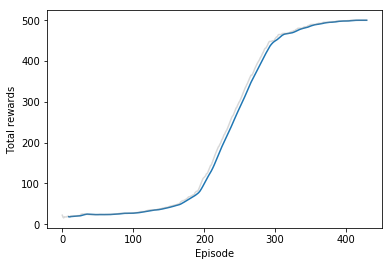

In [57]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

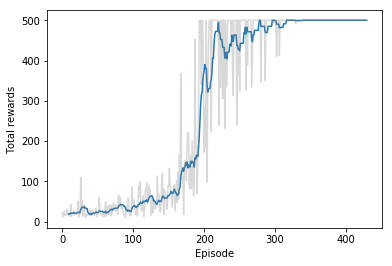

In [58]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [60]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [67]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [62]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.